# Holistic Data Preparer 
Customer credit risk dataset


## 1. Load Libraries and Dataset

In [95]:
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from scipy import stats
import matplotlib.pyplot as plt

### 3.import dataset

In [96]:
df = pd.read_csv('Customer_Credit_Risk_Dataset.csv')
df.sample(5)

,customer_id,age,gender,region,education_level,employment_type,annual_income,loan_amount,loan_purpose,credit_score,repayment_history,transaction_count,spending_ratio,default_flag,join_date
487,10488,51.0,Male,North,Primary,Self-Employed,931742.132764,563728.362562,Other,471.305427,10,138,25.563973,0,2016-05-07
13,10014,60.0,Male,North,Primary,Unemployed,937070.016482,593591.206124,Business,631.313040,9,158,11.802208,0,2020-05-01
408,10409,48.0,Male,East,Post-Graduate,Salaried,473792.358789,792090.636677,Business,622.268394,11,172,40.823451,0,2024-03-11
379,10380,43.0,Male,South,Secondary,Self-Employed,524095.823673,290065.732160,Home,612.772752,5,187,45.072248,0,2016-08-23
4,10005,28.0,Male,East,Secondary,Salaried,761479.456448,73023.533212,Business,852.862892,7,179,21.846702,0,2015-06-19


In [97]:
import json

with open("customer metadata.json", "r") as file:
    data = json.load(file)

df_json = pd.json_normalize(data)
df_json.head()

,Customer_ID,Age,Gender,Income,Total_Purchases,Avg_Order_Value,Tenure_Months,Churn
0,10001,56.0,Male,69812.0,23.0,174.05,26.0,0.0
1,10002,69.0,Female,70500.0,22.0,163.71,42.0,0.0
2,10003,46.0,Female,99151.0,2.0,321.47,41.0,0.0
3,10004,32.0,Male,78643.0,31.0,184.42,36.0,0.0
4,10005,60.0,Female,64900.0,11.0,82.77,23.0,1.0


In [98]:
import mysql.connector
conn = mysql.connector.connect(
    host="localhost",
    user="root",
    password="admin",
    database="AirlineRoutesData"
)

query = "select * from airlineroutesdata_2000"
df_sql = pd.read_sql(query, conn)
df_sql.head()

C:\Users\ishan\AppData\Local\Temp\ipykernel_3028\1538914096.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_sql = pd.read_sql(query, conn)


,FlightID,Origin,Destination,RouteCode,FlightDate,FlightDurationMins,AircraftType,SeatsAvailable,SeatsSold,Revenue,OperationalCost
0,F100000,PNQ,COK,PNQ-COK,2023-01-22,158,ATR72,149,110,359810,210981
1,F100001,HYD,CCU,HYD-CCU,2023-12-29,151,B738,119,48,206688,92717
2,F100002,GOI,PNQ,GOI-PNQ,2023-04-06,81,B738,114,79,622994,173422
3,F100003,MAA,AMD,MAA-AMD,2023-01-27,123,B737,75,56,318248,123829
4,F100004,PNQ,DEL,PNQ-DEL,2023-12-31,136,B738,88,85,369325,205610


# Part C : Data Understanding & cleaning

### 4.Data Exploration

In [99]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        500 non-null    int64  
 1   age                475 non-null    float64
 2   gender             500 non-null    object 
 3   region             500 non-null    object 
 4   education_level    500 non-null    object 
 5   employment_type    475 non-null    object 
 6   annual_income      475 non-null    float64
 7   loan_amount        500 non-null    float64
 8   loan_purpose       500 non-null    object 
 9   credit_score       475 non-null    float64
 10  repayment_history  500 non-null    int64  
 11  transaction_count  500 non-null    int64  
 12  spending_ratio     500 non-null    float64
 13  default_flag       500 non-null    int64  
 14  join_date          500 non-null    object 
dtypes: float64(5), int64(4), object(6)
memory usage: 58.7+ KB


In [100]:
df.describe(include="all")


,customer_id,age,gender,region,education_level,employment_type,annual_income,loan_amount,loan_purpose,credit_score,repayment_history,transaction_count,spending_ratio,default_flag,join_date
count,500.000000,475.000000,500,500,500,475,4.750000e+02,5.000000e+02,500,475.000000,500.000000,500.000000,500.000000,500.000000,500
unique,NaN,NaN,3,4,4,3,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,471
top,NaN,NaN,Male,North,Post-Graduate,Self-Employed,NaN,NaN,Home,NaN,NaN,NaN,NaN,NaN,2018-12-14
freq,NaN,NaN,330,136,133,168,NaN,NaN,114,NaN,NaN,NaN,NaN,NaN,2
mean,10250.500000,43.280000,NaN,NaN,NaN,NaN,6.498615e+05,3.395583e+05,NaN,652.164615,5.704000,105.322000,27.236065,0.264000,NaN
std,144.481833,12.700689,NaN,NaN,NaN,NaN,4.375798e+05,3.659677e+05,NaN,100.467586,3.439774,57.298836,15.005458,0.441241,NaN
min,10001.000000,21.000000,NaN,NaN,NaN,NaN,-1.015543e+05,5.314554e+02,NaN,317.524428,0.000000,5.000000,0.779279,0.000000,NaN
25%,10125.750000,32.000000,NaN,NaN,NaN,NaN,4.294511e+05,9.299811e+04,NaN,581.908404,3.000000,54.000000,15.175355,0.000000,NaN
50%,10250.500000,45.000000,NaN,NaN,NaN,NaN,5.950537e+05,2.357874e+05,NaN,650.137965,6.000000,106.000000,25.982205,0.000000,NaN
75%,10375.250000,53.500000,NaN,NaN,NaN,NaN,7.962655e+05,4.629116e+05,NaN,720.009997,9.000000,156.000000,37.545394,1.000000,NaN


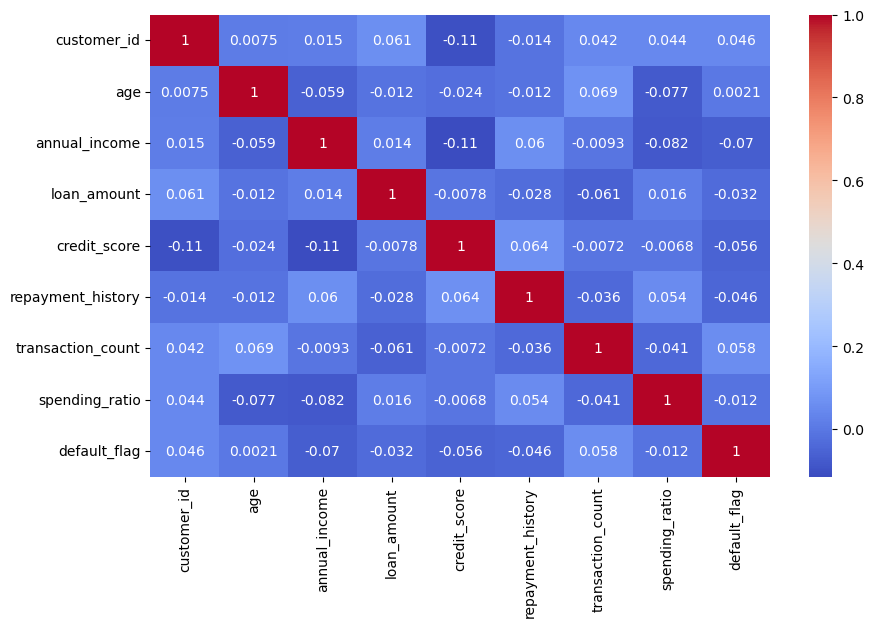

In [101]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")
plt.show()


heatmap visualizes relationships between numerical features. Most variables show low to moderate correlation

## 6.Handling Missing Values

In [102]:
df.isnull().sum()


customer_id           0
age                  25
gender                0
region                0
education_level       0
employment_type      25
annual_income        25
loan_amount           0
loan_purpose          0
credit_score         25
repayment_history     0
transaction_count     0
spending_ratio        0
default_flag          0
join_date             0
dtype: int64

* Simple Imputer(numerical:mean/median)

In [103]:
mean_imputer = SimpleImputer(strategy="mean")
df["age"] = mean_imputer.fit_transform(df[["age"]])


In [104]:
median_imputer = SimpleImputer(strategy="median")
df[["annual_income","credit_score"]] = median_imputer.fit_transform(
    df[["annual_income","credit_score"]]
)


* Simple Imputer (Category:most frequent)

In [105]:
cat_imputer = SimpleImputer(strategy="most_frequent")
df[["gender","employment_type"]] = cat_imputer.fit_transform(
    df[["gender","employment_type"]]
)


* KNN Imputer (multivariate)

In [106]:
knn_imputer = KNNImputer(n_neighbors=5)
df[["annual_income","loan_amount","credit_score"]] = knn_imputer.fit_transform(
    df[["annual_income","loan_amount","credit_score"]]
)


* MICE Algorithem

In [107]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

mice = IterativeImputer(random_state=42)
df[["annual_income","loan_amount","credit_score"]] = mice.fit_transform(
    df[["annual_income","loan_amount","credit_score"]]
)


* Complete case analysis 

In [108]:
def random_sample_imputation(df, column):
    random_sample = df[column].dropna().sample(
        df[column].isnull().sum(),
        random_state=42
    )
    random_sample.index = df[df[column].isnull()].index
    df.loc[df[column].isnull(), column] = random_sample

random_sample_imputation(df, "credit_score")


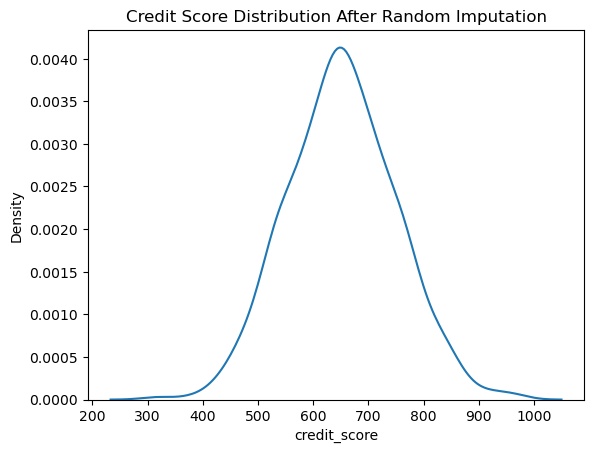

In [109]:
sns.kdeplot(df["credit_score"])
plt.title("Credit Score Distribution After Random Imputation")
plt.show()

The KDE plot shows that after random imputation, the credit score distribution remains smooth and approximately normal, centered around the mid-range scores.

In [110]:
df.isnull().sum()


customer_id          0
age                  0
gender               0
region               0
education_level      0
employment_type      0
annual_income        0
loan_amount          0
loan_purpose         0
credit_score         0
repayment_history    0
transaction_count    0
spending_ratio       0
default_flag         0
join_date            0
dtype: int64

## Part D: Outlier Handling

In [111]:
from scipy.stats import zscore

df = df[(zscore(df["annual_income"]) < 3)]

In [112]:
Q1 = df["annual_income"].quantile(0.25)
Q3 = df["annual_income"].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df["annual_income"] = df["annual_income"].clip(lower, upper)

In [113]:
df["debt_to_income"] = df["loan_amount"] / df["annual_income"]

In [114]:
lower_limit = df["annual_income"].quantile(0.01)
upper_limit = df["annual_income"].quantile(0.99)

lower_limit, upper_limit

(np.float64(2845.301003046153), np.float64(1221745.496838938))

In [115]:
from scipy.stats.mstats import winsorize

df["annual_income_winsor"] = winsorize(
    df["annual_income"],
    limits=[0.05, 0.05]
)

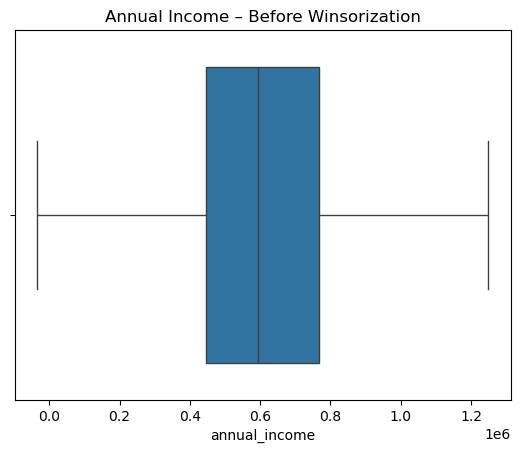

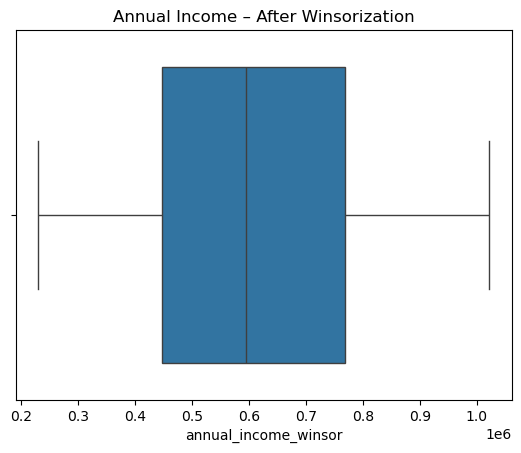

In [116]:
plt.figure()
sns.boxplot(x=df["annual_income"])
plt.title("Annual Income – Before Winsorization")
plt.show()

plt.figure()
sns.boxplot(x=df["annual_income_winsor"])
plt.title("Annual Income – After Winsorization")
plt.show()

Before winsorization, the boxplot shows extreme outliers in annual income, causing a long tail and high variability.

After winsorization, extreme values are capped, resulting in a more compact distribution while preserving the overall data pattern.

## PART E: FEATURE ENGINEERING

#### 8.Handling Variable Types

In [117]:
df[["age", "spending_ratio", "gender", "region"]].head()

,age,spending_ratio,gender,region
0,59.0,3.801693,Male,East
1,49.0,18.187881,Female,West
2,35.0,29.316614,Male,East
3,63.0,11.367140,Female,East
4,28.0,21.846702,Male,East


In [118]:
df["spending_ratio_log"] = np.log1p(df["spending_ratio"])
df_encoded = pd.get_dummies(
    df,
    columns=["gender", "region"],
    drop_first=True
)

In [119]:
df_encoded[
    ["age", "spending_ratio_log"] +
    [col for col in df_encoded.columns if "gender_" in col or "region_" in col]
].head()

,age,spending_ratio_log,gender_Male,gender_Other,region_North,region_South,region_West
0,59.0,1.568969,True,False,False,False,False
1,49.0,2.954279,False,False,False,False,True
2,35.0,3.411696,True,False,False,False,False
3,63.0,2.515043,False,False,False,False,False
4,28.0,3.128807,True,False,False,False,False


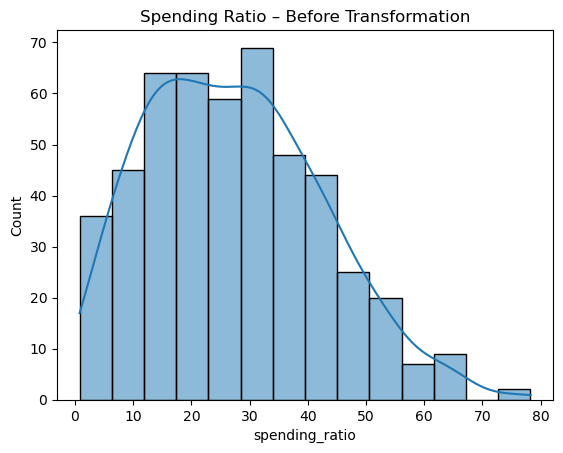

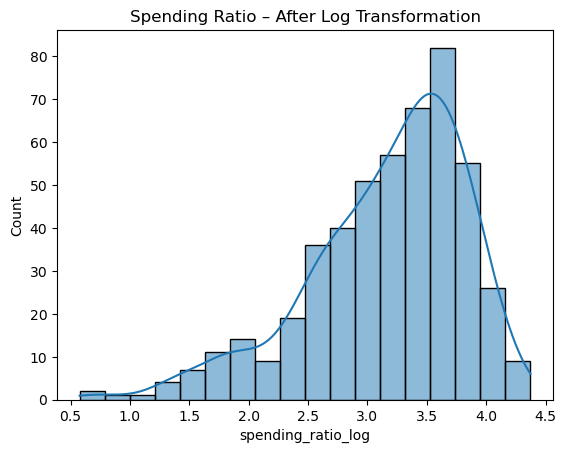

In [120]:
plt.figure()
sns.histplot(df["spending_ratio"], kde=True)
plt.title("Spending Ratio – Before Transformation")
plt.show()

plt.figure()
sns.histplot(df["spending_ratio_log"], kde=True)
plt.title("Spending Ratio – After Log Transformation")
plt.show()

Before transformation, the spending ratio is right-skewed, with most values concentrated at the lower end and a long tail.

After log transformation, the distribution becomes more symmetric and closer to normal, making it better suited for modeling.

* Handling Date & Time Variables

In [121]:
df["join_date"] = pd.to_datetime(df["join_date"])

df["join year"] = df["join_date"].dt.year
df["join month"] = df["join_date"].dt.month
df["join day"] = df["join_date"].dt.day
df["join weekday"] = df["join_date"].dt.weekday


In [122]:
df[["join_date","join year", "join month", "join day", "join weekday"]].head()


,join_date,join year,join month,join day,join weekday
0,2017-05-17,2017,5,17,2
1,2019-06-15,2019,6,15,5
2,2019-09-28,2019,9,28,5
3,2015-10-05,2015,10,5,0
4,2015-06-19,2015,6,19,4


## 9.Encoding Categorical cariables:

* Ordinal Encoding(edu. level)

In [123]:
df["education_level"].value_counts()

education_level
Secondary        130
Post-Graduate    129
Primary          118
Graduate         115
Name: count, dtype: int64

In [124]:
from sklearn.preprocessing import OrdinalEncoder

education_order = [["Primary", "Secondary", "Graduate", "Post-Graduate"]]

ordinal_encoder = OrdinalEncoder(categories=education_order)
df["education level encoded"] = ordinal_encoder.fit_transform(
    df[["education_level"]]
)

In [125]:
df[["education_level", "education level encoded"]].head()

,education_level,education level encoded
0,Graduate,2.0
1,Primary,0.0
2,Post-Graduate,3.0
3,Secondary,1.0
4,Secondary,1.0


* Lable Encoding(gender)

In [126]:
df["gender"].value_counts()

gender
Male      323
Female    147
Other      22
Name: count, dtype: int64

In [127]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
df["gender_encoded"] = label_encoder.fit_transform(df["gender"])

In [128]:
df[["gender", "gender_encoded"]].head()

,gender,gender_encoded
0,Male,1
1,Female,0
2,Male,1
3,Female,0
4,Male,1


* One-Hot Encoding(region & loan purpose)

In [129]:
df[["region", "loan_purpose"]].head()

,region,loan_purpose
0,East,Education
1,West,Education
2,East,Other
3,East,Education
4,East,Business


In [130]:
df_encoded = pd.get_dummies(
    df,
    columns=["region", "loan_purpose"],
    drop_first=True
)

In [131]:
encoded_columns = [col for col in df_encoded.columns if "region_" in col or "loan_purpose_" in col]
df_encoded[encoded_columns].head()

,region_North,region_South,region_West,loan_purpose_Car,loan_purpose_Education,loan_purpose_Home,loan_purpose_Other
0,False,False,False,False,True,False,False
1,False,False,True,False,True,False,False
2,False,False,False,False,False,False,True
3,False,False,False,False,True,False,False
4,False,False,False,False,False,False,False


In [132]:
df[["education_level", "gender", "region", "loan_purpose"]].dtypes

education_level    object
gender             object
region             object
loan_purpose       object
dtype: object

### 10.Encoding Numerical Features

* Binning (diacretize income into gropus)


Binning divides a continuous numerical variable into fixed intervals (bins), converting it into a categorical feature.

In [133]:
df["annual_income"].describe()

count    4.920000e+02
mean     6.035886e+05
std      2.457680e+05
min     -3.377597e+04
25%      4.473199e+05
50%      5.950537e+05
75%      7.680504e+05
max      1.249146e+06
Name: annual_income, dtype: float64

In [134]:
df["income_bin"] = pd.cut(
    df["annual_income"],
    bins=4,
    labels=["Low", "Medium", "High", "Very High"]
)

In [135]:
df[["annual_income", "income_bin"]].head()

,annual_income,income_bin
0,267192.551821,Low
1,669582.265305,High
2,580230.313098,Medium
3,229928.975448,Low
4,761479.456448,High


* Discretization (Repayment History)

Discretization converts count-based numerical values into risk categories.

In [136]:
df["repayment_history"].value_counts().sort_index()

repayment_history
0     30
1     40
2     40
3     53
4     36
5     46
6     42
7     32
8     35
9     44
10    49
11    45
Name: count, dtype: int64

In [137]:
df["repayment_risk"] = pd.cut(
    df["repayment_history"],
    bins=[-1, 3, 5, 50],
    labels=["No Miss", "Low Risk", "High Risk"]
)

In [138]:
df[["repayment_history", "repayment_risk"]].sample(11)

,repayment_history,repayment_risk
98,9,High Risk
422,5,Low Risk
461,4,Low Risk
220,6,High Risk
342,1,No Miss
266,9,High Risk
340,9,High Risk
24,4,Low Risk
458,5,Low Risk
151,4,Low Risk


* Binarization (Credit Score > Threshold)

Binarization converts numerical values into binary flags based on a predefined threshold.

In [139]:
df["credit_score"].describe()

count    492.000000
mean     652.838550
std       97.494224
min      317.524428
25%      585.729796
50%      650.137965
75%      717.347838
max      965.356343
Name: credit_score, dtype: float64

In [140]:
df["good_credit_flag"] = (df["credit_score"] > 700).astype(int)

In [141]:
df[["credit_score", "good_credit_flag"]].head()

,credit_score,good_credit_flag
0,381.521195,0
1,675.957356,0
2,645.429977,0
3,573.500805,0
4,852.862892,1


* Quantile Binning (Transaction Count)

Quantile Binning divides data so that each bin has an equal number of observations.

In [142]:
df["transaction_count"].describe()

count    492.000000
mean     105.469512
std       57.554376
min        5.000000
25%       54.000000
50%      106.000000
75%      157.000000
max      199.000000
Name: transaction_count, dtype: float64

In [143]:
df["transaction quantile"] = pd.qcut(
    df["transaction_count"],
    q=4,
    labels=["Very Low", "Low", "High", "Very High"]
)

In [144]:
df[["transaction_count", "transaction quantile"]].head()

,transaction_count,transaction quantile
0,76,Low
1,191,Very High
2,56,Low
3,122,High
4,179,Very High


* K-Means Binning (Transaction count)

K-Means Binning uses clustering to group numerical values based on similarity, rather than fixed rules.

In [145]:
df[["transaction_count"]].head()

,transaction_count
0,76
1,191
2,56
3,122
4,179


In [146]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42)
df["transaction_kmeans_bin"] = kmeans.fit_predict(
    df[["transaction_count"]]
)

c:\Users\ishan\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


In [147]:
df[["transaction_count", "transaction_kmeans_bin"]].head()

,transaction_count,transaction_kmeans_bin
0,76,0
1,191,1
2,56,2
3,122,0
4,179,1


## Part F: Feature Scaling

* Standardization (Z-Score Scaling)

In [148]:
num_cols = ["annual_income", "loan_amount", "transaction_count", "repayment_history"]

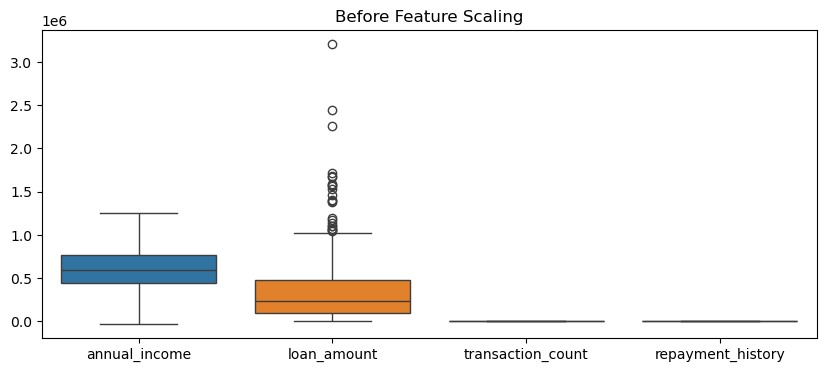

In [149]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df[num_cols])
plt.title("Before Feature Scaling")
plt.show()


In [150]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_standardized = df.copy()

df_standardized[["annual_income", "loan_amount"]] = scaler.fit_transform(
    df[["annual_income", "loan_amount"]]
)

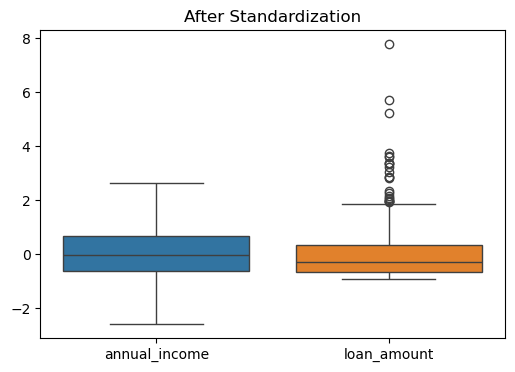

In [151]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df_standardized[["annual_income", "loan_amount"]])
plt.title("After Standardization")
plt.show()

* Min-Max Scaling (Normalization)

In [152]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler()
df_minmax = df.copy()

df_minmax[num_cols] = minmax.fit_transform(df[num_cols])

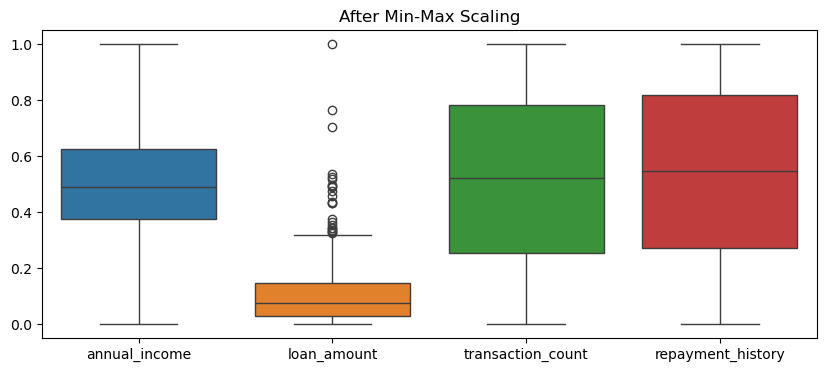

In [153]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df_minmax[num_cols])
plt.title("After Min-Max Scaling")
plt.show()

* MaxAbs Scaling

In [154]:
from sklearn.preprocessing import MaxAbsScaler

maxabs = MaxAbsScaler()
df_maxabs = df.copy()

df_maxabs[num_cols] = maxabs.fit_transform(df[num_cols])

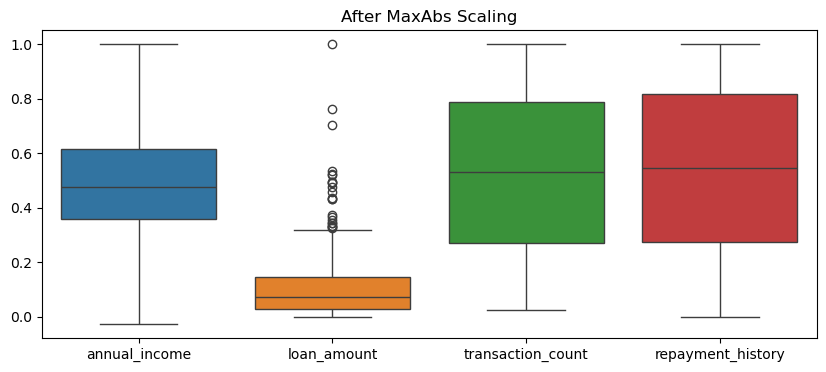

In [155]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df_maxabs[num_cols])
plt.title("After MaxAbs Scaling")
plt.show()

* Robust Scaling

In [156]:
from sklearn.preprocessing import RobustScaler

robust = RobustScaler()
df_robust = df.copy()

df_robust[num_cols] = robust.fit_transform(df[num_cols])

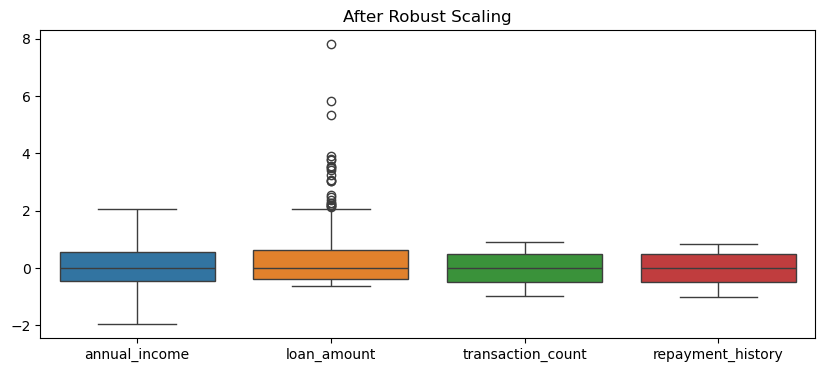

In [157]:
plt.figure(figsize=(10,4))
sns.boxplot(data=df_robust[num_cols])
plt.title("After Robust Scaling")
plt.show()

## Part G: Feature Construction & Transformation

* FunctionTransformer

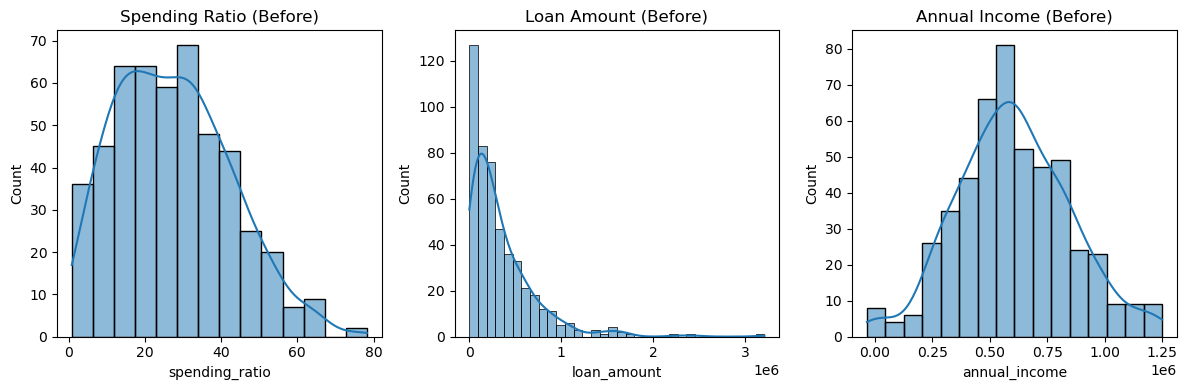

In [158]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.histplot(df["spending_ratio"], kde=True)
plt.title("Spending Ratio (Before)")

plt.subplot(1,3,2)
sns.histplot(df["loan_amount"], kde=True)
plt.title("Loan Amount (Before)")

plt.subplot(1,3,3)
sns.histplot(df["annual_income"], kde=True)
plt.title("Annual Income (Before)")

plt.tight_layout()
plt.show()

In [159]:
df_func = df.copy()

df_func["spending_log"] = np.log1p(df["spending_ratio"])
df_func["spending_reciprocal"] = 1 / (df["spending_ratio"] + 1)
df_func["spending_sqrt"] = np.sqrt(df["spending_ratio"])


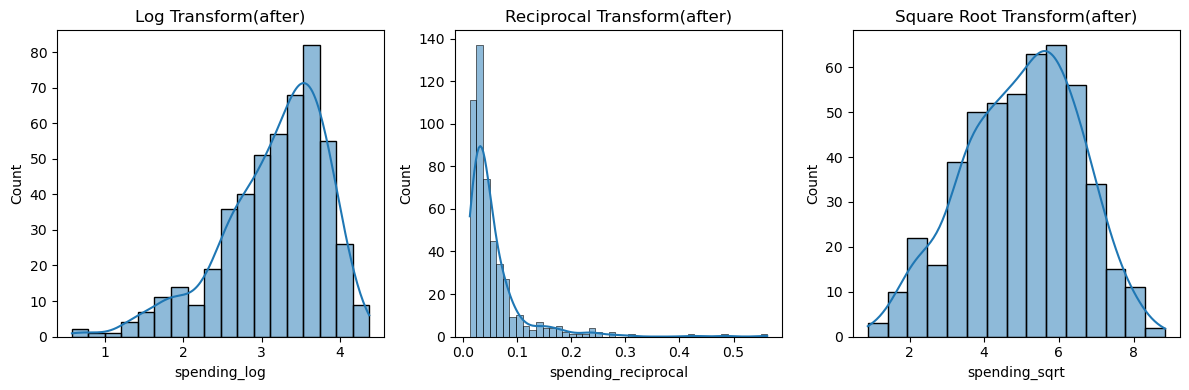

In [176]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
sns.histplot(df_func["spending_log"], kde=True)
plt.title("Log Transform(after)")

plt.subplot(1,3,2)
sns.histplot(df_func["spending_reciprocal"], kde=True)
plt.title("Reciprocal Transform(after)")

plt.subplot(1,3,3)
sns.histplot(df_func["spending_sqrt"], kde=True)
plt.title("Square Root Transform(after)")

plt.tight_layout()
plt.show()

Skewness reduced significantly, smoother distribution.

## PowerTransformer

* Yeo-Johnson Transformation

In [ ]:
df_boxcox = df.copy()

df_boxcox[["loan_amount"]] = (
    df_boxcox[["loan_amount"]] + 1
)

In [162]:
from sklearn.preprocessing import PowerTransformer

pt_boxcox = PowerTransformer(method="box-cox")

df_boxcox[["loan_amount"]] = pt_boxcox.fit_transform(
    df_boxcox[["loan_amount"]]
)

In [ ]:
from sklearn.preprocessing import PowerTransformer

pt_yeo = PowerTransformer(method="yeo-johnson")

df_yeo = df.copy()
df_yeo[["loan_amount", "annual_income"]] = pt_yeo.fit_transform(
    df[["loan_amount", "annual_income"]]
)

In [ ]:
pt_yeo = PowerTransformer(method="yeo-johnson")

df_yeo = df.copy()
df_yeo[["loan_amount", "annual_income"]] = pt_yeo.fit_transform(
    df[["loan_amount", "annual_income"]]
)

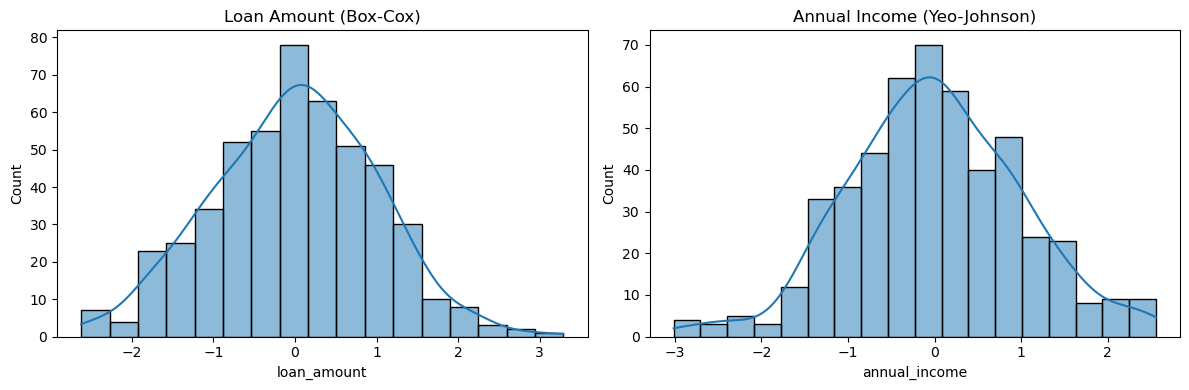

In [165]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(df_boxcox["loan_amount"], kde=True)
plt.title("Loan Amount (Box-Cox)")

plt.subplot(1,2,2)
sns.histplot(df_yeo["annual_income"], kde=True)
plt.title("Annual Income (Yeo-Johnson)")

plt.tight_layout()
plt.show()

Distributions become near-normal

Improved symmetry

* ColumnTransforme

In [166]:
num_cols = [
    "age", "annual_income", "loan_amount",
    "credit_score", "spending_ratio"
]
cat_cols = ["gender", "region", "loan_purpose"]
ord_col = ["education_level"]

In [167]:
df[num_cols + cat_cols + ord_col].head()

,age,annual_income,loan_amount,credit_score,spending_ratio,gender,region,loan_purpose,education_level
0,59.0,267192.551821,26450.210736,381.521195,3.801693,Male,East,Education,Graduate
1,49.0,669582.265305,152932.227244,675.957356,18.187881,Female,West,Education,Primary
2,35.0,580230.313098,722832.807891,645.429977,29.316614,Male,East,Other,Post-Graduate
3,63.0,229928.975448,495113.333399,573.500805,11.367140,Female,East,Education,Secondary
4,28.0,761479.456448,73023.533212,852.862892,21.846702,Male,East,Business,Secondary


In [168]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler, OneHotEncoder, OrdinalEncoder
)
from sklearn.impute import SimpleImputer


In [169]:
num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first", sparse_output=False))
])
ord_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(categories=[
        ["Primary", "Secondary", "Graduate", "Post-Graduate"]
    ]))
])

In [170]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_pipeline, num_cols),
        ("cat", cat_pipeline, cat_cols),
        ("ord", ord_pipeline, ord_col)
    ]
)

In [171]:
X_before = df[num_cols + cat_cols + ord_col]

X_after = preprocessor.fit_transform(X_before)

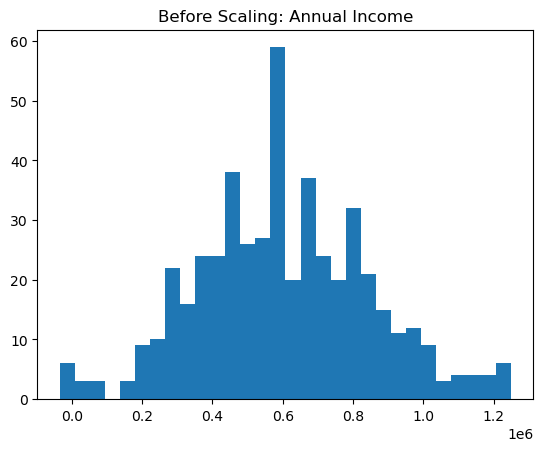

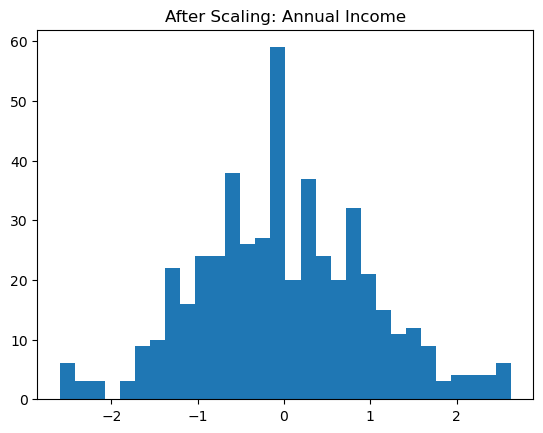

In [ ]:
plt.figure()
plt.hist(df["annual_income"], bins=30)
plt.title("Before Scaling: Annual Income")
plt.show()

income_scaled = X_after[:, 1]  # scaled annual_income

plt.figure()
plt.hist(income_scaled, bins=30)
plt.title("After Scaling: Annual Income")
plt.show()

In [173]:
df["debt to income ratio"] = df["loan_amount"] / df["annual_income"]

df["avg monthly transactions"] = df["transaction_count"] / 6

df["spending to income"] = df["spending_ratio"] / df["annual_income"]

In [174]:
df[
    ["debt to income ratio", "avg monthly transactions", "spending to income"]
].head()

,debt to income ratio,avg monthly transactions,spending to income
0,0.098993,12.666667,0.000014
1,0.228399,31.833333,0.000027
2,1.245769,9.333333,0.000051
3,2.153332,20.333333,0.000049
4,0.095897,29.833333,0.000029


In [178]:
df.to_csv("Final Cleaned Dataset.csv", index=False)
